In [1]:
import pandas as pd
import numpy as np

In [2]:
# pip install pmdarima

# SECOND ML MODEL
### Warning Sepsis Risk by Predicting the Temperature

In [3]:
temp_df = pd.read_csv("../processed_data/chartevents_6_temp.csv").drop(columns = ['Temperature_C_all', 'Temperature_F_all', 'new_temp_c_all'])

In [4]:
temp_df["charttime"] = pd.to_datetime(temp_df["charttime"])

In [5]:
temp_df['subject_id'].value_counts()

subject_id
21280    1664
12613    1638
11923    1441
1785     1307
3932     1296
         ... 
8712        1
10373       1
5927        1
19768       1
16231       1
Name: count, Length: 22289, dtype: int64

I am going to take a look the patient (subject_id: 21280) who has the most hospital information.

In [15]:
patient_21280_df = temp_df[temp_df['subject_id'] == 21280].set_index('charttime')
patient_21280_df

,subject_id,hadm_id,icustay_id,Temperature_final
charttime,,,,
2159-02-02 16:00:00,21280,100374,224298.0,37.000000
2159-02-03 00:00:00,21280,100374,224298.0,37.666698
2159-02-03 04:00:00,21280,100374,224298.0,36.611099
2159-02-03 08:00:00,21280,100374,224298.0,36.833302
2159-02-03 12:00:00,21280,100374,224298.0,36.833302
...,...,...,...,...
2164-02-15 15:00:00,21280,199369,229375.0,38.333302
2164-02-15 22:00:00,21280,199369,229375.0,38.444401
2164-02-16 03:00:00,21280,199369,229375.0,39.111099


<Axes: xlabel='charttime'>

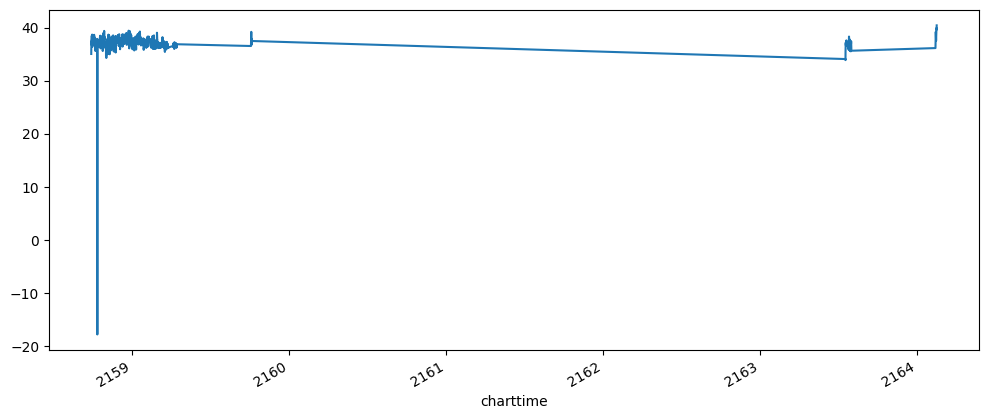

In [16]:
patient_21280_df['Temperature_final'].plot(figsize=(12,5))

Check for Stationarity

In [18]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF: ", dftest[0])
    print("2. P-value: ", dftest[1])
    print("3. Num of Lags: ", dftest[2])
    print("4. Num of Observations Used For ADF Registration and Critical Values Calculation: ", dftest[3])
    print("5. Critical values: ")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [19]:
ad_test(patient_21280_df['Temperature_final'])

1. ADF:  -12.60581187301637
2. P-value:  1.6969070660125424e-23
3. Num of Lags:  5
4. Num of Observations Used For ADF Registration and Critical Values Calculation:  1658
5. Critical values: 
	 1% :  -3.434300212992577
	 5% :  -2.863284793874921
	 10% :  -2.567698886736967


Figure Out Order for ARIMA Model

In [20]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [21]:
stepwise_fit = auto_arima(patient_21280_df['Temperature_final'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6180.785, Time=1.54 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6288.334, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6215.992, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6231.830, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16752.770, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6180.663, Time=1.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6204.596, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6180.548, Time=0.67 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6190.468, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6190.246, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6227.599, Time=0.25 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 4.498 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1664
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3086.274
Date:                Sun, 04 Feb 2024   AIC                           6180.548
Time:                        20:56:45   BIC                           6202.216
Sample:                             0   HQIC                          6188.578
                               - 1664                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.2054      1.542      8.563      0.000      10.183      16.228
ar.L1          0.6438      0.042     15.429      0.000       0.562       0.726
ma.L1         -0.4555      0.042    -10.727      0.000      -0.539      -0.372
sigma2         2.3804      0.008    303.214      0.000       2.365       2.396
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):          61753351.85
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                           -26.51
Prob(H) (two-sided):                  0.00   Kurtosis:                       945.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
from statsmodels.tsa.arima.model import ARIMA

Split Data into Training and Testing

In [34]:
print(patient_21280_df.shape)
train = patient_21280_df.iloc[:-30]
test = patient_21280_df.iloc[-30:]
print(train.shape, test.shape)

(1664, 4)
(1634, 4) (30, 4)


Train the Model

In [35]:
model = ARIMA(train['Temperature_final'], order = (1, 0, 5))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Temperature_final   No. Observations:                 1634
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -3028.913
Date:                Sun, 04 Feb 2024   AIC                           6073.825
Time:                        21:14:34   BIC                           6117.015
Sample:                             0   HQIC                          6089.846
                               - 1634                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.0706      0.176    210.122      0.000      36.725      37.416
ar.L1          0.9039      0.072     12.563      0.000       0.763       1.045
ma.L1         -0.7477      0.072    -10.386      0.000      -0.889      -0.607
ma.L2         -0.0175      0.015     -1.194      0.232      -0.046       0.011
ma.L3         -0.0356      0.017     -2.103      0.035      -0.069      -0.002
ma.L4         -0.0013      0.016     -0.083      0.934      -0.033       0.030
ma.L5          0.0014      0.017      0.082      0.934      -0.032       0.035
sigma2         2.3854      0.008    290.496      0.000       2.369       2.402
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          62880607.64
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              17.62   Skew:                           -27.05
Prob(H) (two-sided):                  0.00   Kurtosis:                       962.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Make Predictions on Test Sets

In [38]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start = start, end = end, typ = 'levels')
print(pred)
# pred.index = patient_21280_df.index[start:end+1]
# print(pred)

1634    36.757434
1635    36.805020
1636    36.839626
1637    36.861674
1638    36.881394
1639    36.899574
1640    36.916007
1641    36.930861
1642    36.944287
1643    36.956423
1644    36.967392
1645    36.977307
1646    36.986269
1647    36.994370
1648    37.001692
1649    37.008310
1650    37.014293
1651    37.019700
1652    37.024587
1653    37.029005
1654    37.032998
1655    37.036608
1656    37.039870
1657    37.042819
1658    37.045485
1659    37.047894
1660    37.050072
1661    37.052040
1662    37.053820
1663    37.055428
Name: predicted_mean, dtype: float64


<Axes: xlabel='charttime'>

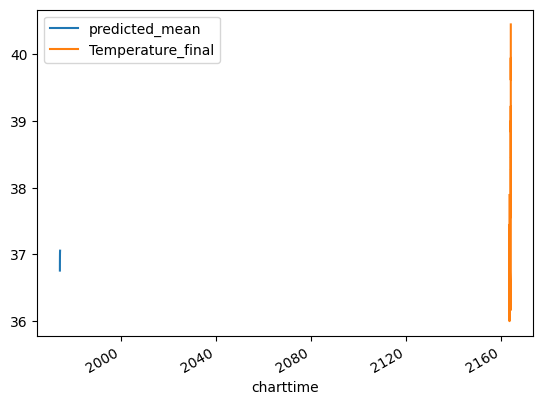

In [39]:
pred.plot(legend = True)
test['Temperature_final'].plot(legend = True)

In [40]:
test['Temperature_final'].mean()

38.19258689880371

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [42]:
rmse = sqrt(mean_squared_error(pred, test['Temperature_final']))
rmse

1.6534199018984093

In [43]:
model2 = ARIMA(patient_21280_df['Temperature_final'], order = (1, 0, 5))
model2 = model2.fit()
patient_21280_df.tail()

,subject_id,hadm_id,icustay_id,Temperature_final
charttime,,,,
2164-02-15 15:00:00,21280,199369,229375.0,38.333302
2164-02-15 22:00:00,21280,199369,229375.0,38.444401
2164-02-16 03:00:00,21280,199369,229375.0,39.111099
2164-02-16 07:00:00,21280,199369,229375.0,39.944401
2164-02-16 11:00:00,21280,199369,229375.0,39.611099


For Future Dates

In [44]:
# index_future_dates = pd.date_range(starts = , end = )
# print(index_future_dates)
pred = model2.predict(start = len(patient_21280_df), end = len(patient_21280_df)+30, typ = 'level').rename('ARIMA Predictions')
# print(comp_pred)
# pred.index = index_future_dates
print(pred)

1664    38.199219
1665    37.997461
1666    37.863375
1667    37.796873
1668    37.734469
1669    37.673837
1670    37.618987
1671    37.569367
1672    37.524478
1673    37.483870
1674    37.447134
1675    37.413900
1676    37.383836
1677    37.356638
1678    37.332033
1679    37.309775
1680    37.289639
1681    37.271423
1682    37.254944
1683    37.240036
1684    37.226550
1685    37.214349
1686    37.203312
1687    37.193328
1688    37.184295
1689    37.176124
1690    37.168732
1691    37.162045
1692    37.155995
1693    37.150522
1694    37.145571
Name: ARIMA Predictions, dtype: float64
